**Requirements/Dependecies**

In [1]:
!pip install rasterio
import rasterio
import numpy as np
from rasterio.plot import show, adjust_band
import numpy as np
from rasterio.warp import transform
from rasterio.crs import CRS
from math import sin, cos, sqrt, atan2, radians
import math
import matplotlib.pyplot as plt

     |████████████████████████████████| 19.1MB 220kB/s 


**Load Image**

In [ ]:
dataset = rasterio.open('/content/TQ28ne_DTM_2m.tif')

**Coordinate refernece System**

In [ ]:
dataset.crs

CRS.from_epsg(27700)

**Image bounds**

In [ ]:
dataset.bounds

BoundingBox(left=525000.0, bottom=185000.0, right=530000.0, top=190000.0)

**Affine Transform Info**

In [ ]:
dataset.transform

Affine(2.0, 0.0, 525000.0,
       0.0, -2.0, 190000.0)

**Channels**

In [ ]:
dataset.indexes

(1,)

**Read Channel**

In [ ]:
img = dataset.read(1)

In [ ]:
imgdata = np.array([adjust_band(dataset.read(1)) for i in (3,2,1)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


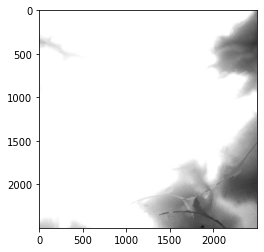

In [ ]:
show(imgdata*3)

**Pixel to Image location in Image CRS**

In [ ]:
x, y = dataset.xy(1, 1)
print(x,y)

525003.0 189997.0


In [ ]:
x, y = dataset.transform * (1000, 1000)
print(x,y)

527000.0 188000.0


In [ ]:
row, column = dataset.index(527000.0, 188000.0)
print(row,column)

1000 1000


**Image CRS to WSG84**

In [ ]:
img_pts = ([(dataset.transform * (x, x)) for x in np.arange(1, 1000, 1)])

WGS84 = CRS.from_epsg(4326)
epsg_27700 = CRS.from_epsg(27700)

def get_coords(img_pts):
  results = []
  for pos in img_pts:
    lat_long = transform(epsg_27700, WGS84,xs=[pos[0]], ys=[pos[1]])
    results.append([lat_long[1][0],lat_long[0][0]])
  return results

lat_longs = get_coords(img_pts)
print(lat_longs)

[[51.594968736823255, -0.19677678491595763], [51.59495031973643, -0.19674863872787507], [51.59493190264304, -0.19672049256255061], [51.594913485543024, -0.1966923464199834], [51.594895068436436, -0.1966642003001736], [51.594876651323275, -0.19663605420312064], [51.59485823420353, -0.1966079081288258], [51.59483981707719, -0.19657976207728786], [51.59482139994427, -0.19655161604850765], [51.59480298280476, -0.19652347004248388], [51.59478456565865, -0.19649532405921785], [51.594766148506, -0.1964671780987092], [51.59474773134672, -0.19643903216095734], [51.59472931418086, -0.19641088624596326], [51.59471089700842, -0.19638274035372522], [51.5946924798294, -0.19635459448424575], [51.59467406264379, -0.19632644863752202], [51.59465564545157, -0.19629830281355629], [51.5946372282528, -0.19627015701234712], [51.59461881104744, -0.19624201123389484], [51.59460039383547, -0.19621386547819988], [51.594581976616944, -0.19618571974526144], [51.59456355939183, -0.19615757403508027], [51.594545142

In [ ]:
new_crs = CRS.from_epsg(4326)
new_coo = transform(dataset.crs, new_crs,xs=[527000.0], ys=[188000.0])
new_coo

([-0.1686700833835037], [51.57656678616968])

In [ ]:
new_coo = transform(new_crs,dataset.crs,xs=[-0.19677678491595763], ys=[51.594968736823255])
new_coo

([525002.0008799589], [189997.99951657146])

**Get Elevation with Image CRS**

In [ ]:
coords = ((525200,189800),)

elevation = "/content/TQ28ne_DTM_2m.tif"
with rasterio.open(elevation) as src:
    vals = src.sample(coords)
    for val in vals:
        print(val[0])

75.087494


**Elevation from Lat Longs**

In [ ]:
WGS84 = CRS.from_epsg(4326)
epsg_27700 = CRS.from_epsg(27700)

def get_elevation(lat_lon,image_path):
  results = []
  #read the data
  src = rasterio.open(image_path)

  for i,ele in enumerate(lat_lon,0):
    lat = ele[0]
    lon = ele[1]
    #Conversion to 
    new_coo = transform(WGS84,epsg_27700,xs=[lon], ys=[lat])
    vals = src.sample(((new_coo[0][0],new_coo[1][0]),))
    for val in vals:
      results.append({"lat":lat,"lon":lon,"elevation":val[0]})
  return results

test_results = get_elevation(lat_longs,'/content/TQ28ne_DTM_2m.tif')

In [ ]:
elevation_measures = [child["elevation"] for child in test_results]
elevation_measures

**BASIC STAT INFO**

In [ ]:
mean_elev=round((sum(elevation_measures)/len(elevation_measures)),3)
min_elev=min(elevation_measures)
max_elev=max(elevation_measures)

In [ ]:
R = 6373.0

lat1 = radians(lat_longs[0][0])
lon1 = radians(lat_longs[0][1])
lat2 = radians(lat_longs[-1][0])
lon2 = radians(lat_longs[-1][1])

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result:", distance)
print("Should be:", 278.546, "km")

Result: 2.8190371472128537
Should be: 278.546 km


**Distance Measure**

In [ ]:
def haversine(lat1,lon1,lat2,lon2):
    lat1_rad=math.radians(lat1)
    lat2_rad=math.radians(lat2)
    lon1_rad=math.radians(lon1)
    lon2_rad=math.radians(lon2)
    delta_lat=lat2_rad-lat1_rad
    delta_lon=lon2_rad-lon1_rad
    a=math.sqrt((math.sin(delta_lat/2))**2+math.cos(lat1_rad)*math.cos(lat2_rad)*(math.sin(delta_lon/2))**2)
    d=2*6371000*math.asin(a)
    return d

d_list=[]
for j in range(len(lat_longs)):
    lat_p=lat_longs[j][0]
    lon_p=lat_longs[j][1]
    dp=haversine(lat_longs[0][0],lat_longs[0][1],lat_p,lon_p)/1000 #km
    d_list.append(dp)
d_list_rev=d_list[::-1]

**Elevation Profile**

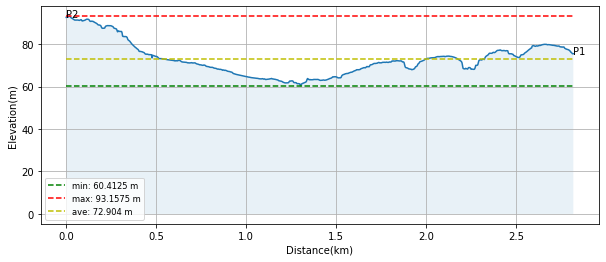

In [ ]:
base_reg=0
plt.figure(figsize=(10,4))
plt.plot(d_list_rev,elevation_measures)
plt.plot([0,distance],[min_elev,min_elev],'--g',label='min: '+str(min_elev)+' m')
plt.plot([0,distance],[max_elev,max_elev],'--r',label='max: '+str(max_elev)+' m')
plt.plot([0,distance],[mean_elev,mean_elev],'--y',label='ave: '+str(mean_elev)+' m')
plt.fill_between(d_list_rev,elevation_measures,base_reg,alpha=0.1)
plt.text(d_list_rev[0],elevation_measures[0],"P1")
plt.text(d_list_rev[-1],elevation_measures[-1],"P2")
plt.xlabel("Distance(km)")
plt.ylabel("Elevation(m)")
plt.grid()
plt.legend(fontsize='small')
plt.show()